# Documentación de Cumplimiento de Requisitos (Trabajo 03)

Este script implementa el **pipeline completo de extracción de características clásicas**, abordando y resolviendo los siguientes puntos obligatorios del enunciado del proyecto:

### Parte 1: Preprocesamiento [Requisito Cumplido]
- [x] **Ecualización de Histograma (CLAHE):** Se implementa la función `_preprocess` aplicando CLAHE (*Contrast Limited Adaptive Histogram Equalization*) a las imágenes de rayos X para resaltar estructuras óseas y pulmonares.

### Parte 2: Extracción de Descriptores Clásicos [Requisito Cumplido]

**A. Descriptores de Forma (Se implementan 3 de 3 requeridos):**
- [x] **HOG (Histogram of Oriented Gradients):** Extracción de vectores de gradientes para capturar la estructura general.
- [x] **Momentos de Hu:** Cálculo de los 7 momentos invariantes a rotación, escala y traslación.
- [x] **Descriptores de Contorno:** Cálculo de Área, Perímetro, Circularidad y Excentricidad tras binarización.

**B. Descriptores de Textura (Se implementan 3 de 3 requeridos):**
- [x] **LBP (Local Binary Patterns):** Generación de histogramas de patrones binarios locales para análisis de textura granular.
- [x] **GLCM (Gray Level Co-occurrence Matrix):** Cálculo de propiedades estadísticas (Contraste, Energía, Homogeneidad, Correlación).
- [x] **Filtros de Gabor:** Aplicación de banco de filtros y extracción de estadísticas de respuesta (Media y Desviación Estándar).

### Parte 3: Preparación para Clasificación [Requisito Cumplido]
- [x] **Creación de Matriz de Características:** El script procesa todo el dataset (`train`, `test`, `val`), concatena todos los descriptores anteriores en un único vector por imagen y genera los archivos `.csv` finales listos para el entrenamiento de modelos (SVM, RF, k-NN).

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

# ==========================================
# 1. CONFIGURACIÓN DE RUTAS (Tus rutas exactas)
# ==========================================
carpeta_preprocesadas = 'data/preprocesadas/'

# Rutas de entrada
rutas = {
    'train': {
        'NORMAL': carpeta_preprocesadas + 'train/NORMAL/',
        'PNEUMONIA': carpeta_preprocesadas + 'train/PNEUMONIA/'
    },
    'test': {
        'NORMAL': carpeta_preprocesadas + 'test/NORMAL/',
        'PNEUMONIA': carpeta_preprocesadas + 'test/PNEUMONIA/'
    },
    'val': {
        'NORMAL': carpeta_preprocesadas + 'val/NORMAL/',
        'PNEUMONIA': carpeta_preprocesadas + 'val/PNEUMONIA/'
    }
}

# Ruta de salida (Ajustada para features clásicos)
salida_base = 'data/caracteristicas/'
salida_clasicas = os.path.join(salida_base, 'clasicas')
os.makedirs(salida_clasicas, exist_ok=True)

# ==========================================
# 2. CLASE EXTRACTORA (Cumpliendo el PDF)
# ==========================================
class ClassicalFeatureExtractor:
    def __init__(self, use_clahe=True):
        self.use_clahe = use_clahe
        # HOG
        self.hog = cv2.HOGDescriptor((64, 128), (16, 16), (8, 8), (8, 8), 9)
        # LBP
        self.lbp_radius = 1
        self.lbp_points = 8 * self.lbp_radius

    def _preprocess(self, image):
        # Asegurar escala de grises
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
        
        # Requisito PDF: Ecualización de histograma (CLAHE)
        if self.use_clahe:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray = clahe.apply(gray)
        return gray

    # --- FORMA (SHAPE) ---
    def _get_hog(self, img_gray):
        resized = cv2.resize(img_gray, (64, 128)) 
        return self.hog.compute(resized).flatten()

    def _get_hu_moments(self, img_gray):
        _, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        moments = cv2.moments(thresh)
        hu = cv2.HuMoments(moments).flatten()
        # Log transform para manejo de escala
        return -np.sign(hu) * np.log10(np.abs(hu) + 1e-7)

    def _get_contour_features(self, img_gray):
        # Area, Perimetro, Circularidad, Excentricidad
        blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
        _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours: return np.zeros(4)
        c = max(contours, key=cv2.contourArea)
        
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        
        eccentricity = 0
        if len(c) >= 5:
            (x, y), (MA, ma), angle = cv2.fitEllipse(c)
            if ma > 0 and MA > 0:
                a, b = ma / 2, MA / 2
                eccentricity = np.sqrt(1 - (b**2 / a**2)) if a > b else 0
                
        return np.array([area, perimeter, circularity, eccentricity])

    # --- TEXTURA ---
    def _get_lbp(self, img_gray):
        lbp = local_binary_pattern(img_gray, self.lbp_points, self.lbp_radius, method="uniform")
        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        return hist

    def _get_glcm(self, img_gray):
        # Propiedades: contraste, disimilitud, homogeneidad, energía, correlación
        glcm = graycomatrix(img_gray, [1], [0, np.pi/2], levels=256, symmetric=True, normed=True)
        props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
        return np.array([graycoprops(glcm, p).mean() for p in props])

    def _get_gabor_stats(self, img_gray):
        # Media y Varianza de filtros Gabor
        ksize = 31
        features = []
        for theta in [0, np.pi/4]: # Dos orientaciones
            kernel = cv2.getGaborKernel((ksize, ksize), 3, theta, np.pi/4, 0.5, 0, ktype=cv2.CV_32F)
            fimg = cv2.filter2D(img_gray, cv2.CV_8UC3, kernel)
            features.extend([fimg.mean(), fimg.std()])
        return np.array(features)

    def extract(self, img_path):
        img = cv2.imread(img_path)
        if img is None: return None
        
        gray = self._preprocess(img)
        
        # Concatenar todos los features
        f_hog = self._get_hog(gray)
        f_hu = self._get_hu_moments(gray)
        f_cont = self._get_contour_features(gray)
        f_lbp = self._get_lbp(gray)
        f_glcm = self._get_glcm(gray)
        f_gabor = self._get_gabor_stats(gray)
        
        return np.concatenate([f_hog, f_hu, f_cont, f_lbp, f_glcm, f_gabor])

# ==========================================
# 3. EJECUCIÓN DEL PIPELINE
# ==========================================

extractor = ClassicalFeatureExtractor(use_clahe=True)

# Iteramos sobre los conjuntos: train, test, val
for dataset_name, clases in rutas.items():
    print(f"\n--- Procesando conjunto: {dataset_name.upper()} ---")
    
    data_features = []
    data_labels = []
    filenames = []
    
    # Iteramos sobre las clases: NORMAL (0), PNEUMONIA (1)
    for clase, ruta_clase in clases.items():
        label = 0 if clase == 'NORMAL' else 1
        
        if not os.path.exists(ruta_clase):
            print(f"Advertencia: La ruta {ruta_clase} no existe. Saltando.")
            continue
            
        imagenes = [f for f in os.listdir(ruta_clase) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Clase {clase}: {len(imagenes)} imágenes.")
        
        for img_name in tqdm(imagenes, desc=f"{dataset_name}/{clase}"):
            img_path = os.path.join(ruta_clase, img_name)
            
            try:
                features = extractor.extract(img_path)
                if features is not None:
                    data_features.append(features)
                    data_labels.append(label)
                    filenames.append(img_name)
            except Exception as e:
                print(f"Error en {img_name}: {e}")

    # Convertir a DataFrame y Guardar
    if data_features:
        # Crear matriz X
        X = np.array(data_features)
        y = np.array(data_labels)
        
        # Guardar como CSV comprimido (mejor manejo que CSV plano para muchos datos)
        # Nombres de columnas genéricos f0, f1... + label + filename
        cols = [f"feat_{i}" for i in range(X.shape[1])]
        df = pd.DataFrame(X, columns=cols)
        df['label'] = y
        df['filename'] = filenames
        
        output_file = os.path.join(salida_clasicas, f'{dataset_name}_features_clasicos.csv')
        df.to_csv(output_file, index=False)
        print(f"✅ Guardado: {output_file} | Shape: {df.shape}")

print("\n--- Proceso completado exitosamente ---")


--- Procesando conjunto: TRAIN ---
Clase NORMAL: 1341 imágenes.


train/NORMAL: 100%|██████████| 1341/1341 [04:42<00:00,  4.76it/s] 


Clase PNEUMONIA: 3875 imágenes.


train/PNEUMONIA: 100%|██████████| 3875/3875 [09:48<00:00,  6.59it/s]  


✅ Guardado: data/caracteristicas/clasicas/train_features_clasicos.csv | Shape: (5216, 3812)

--- Procesando conjunto: TEST ---
Clase NORMAL: 234 imágenes.


test/NORMAL: 100%|██████████| 234/234 [00:41<00:00,  5.70it/s]


Clase PNEUMONIA: 390 imágenes.


test/PNEUMONIA: 100%|██████████| 390/390 [00:40<00:00,  9.55it/s]


✅ Guardado: data/caracteristicas/clasicas/test_features_clasicos.csv | Shape: (624, 3812)

--- Procesando conjunto: VAL ---
Clase NORMAL: 8 imágenes.


val/NORMAL: 100%|██████████| 8/8 [00:00<00:00,  8.03it/s]


Clase PNEUMONIA: 8 imágenes.


val/PNEUMONIA: 100%|██████████| 8/8 [00:01<00:00,  7.20it/s]


✅ Guardado: data/caracteristicas/clasicas/val_features_clasicos.csv | Shape: (16, 3812)

--- Proceso completado exitosamente ---


## Fase 3: Entrenamiento y Evaluación Comparativa (Machine Learning)

En esta sección utilizamos los vectores de características generados previamente (HOG, LBP, Hu, etc.) para entrenar clasificadores supervisados. Este bloque de código aborda los requisitos finales de la **Parte 3** del enunciado del proyecto.

### Puntos del Proyecto Abordados:

#### 1. Normalización de Datos [Requisito 3.2]
- [x] **Estandarización:** Se aplica `StandardScaler` a los datos. Esto es crítico porque características como el "Área" (miles de píxeles) tienen escalas muy diferentes a los "Momentos de Hu" (decimales pequeños), y algoritmos como SVM o k-NN son sensibles a estas escalas.

#### 2. Modelos de Clasificación [Requisito 3.4]
Se implementan y comparan los tres clasificadores solicitados:
- [x] **Support Vector Machine (SVM):** Con kernel RBF para manejar no linealidades.
- [x] **Random Forest:** Un ensamble robusto basado en árboles de decisión.
- [x] **k-Nearest Neighbors (k-NN):** Clasificador basado en distancia.

#### 3. Métricas de Evaluación [Requisito "Métricas requeridas"]
Para cada modelo se calculan y visualizan:
- [x] **Métricas Escalares:** Accuracy, Precision, Recall, F1-Score.
- [x] **Matriz de Confusión:** Para visualizar falsos positivos vs falsos negativos.
- [x] **Curva ROC y AUC:** Para comparar el rendimiento global de los modelos bajo diferentes umbrales.

Cargando datasets...
Normalizando datos...

--- Entrenando SVM ---
✅ SVM completado. Accuracy: 0.7580 | AUC: 0.9168

--- Entrenando Random Forest ---
✅ Random Forest completado. Accuracy: 0.7452 | AUC: 0.8242

--- Entrenando k-NN ---
✅ k-NN completado. Accuracy: 0.7484 | AUC: 0.7779


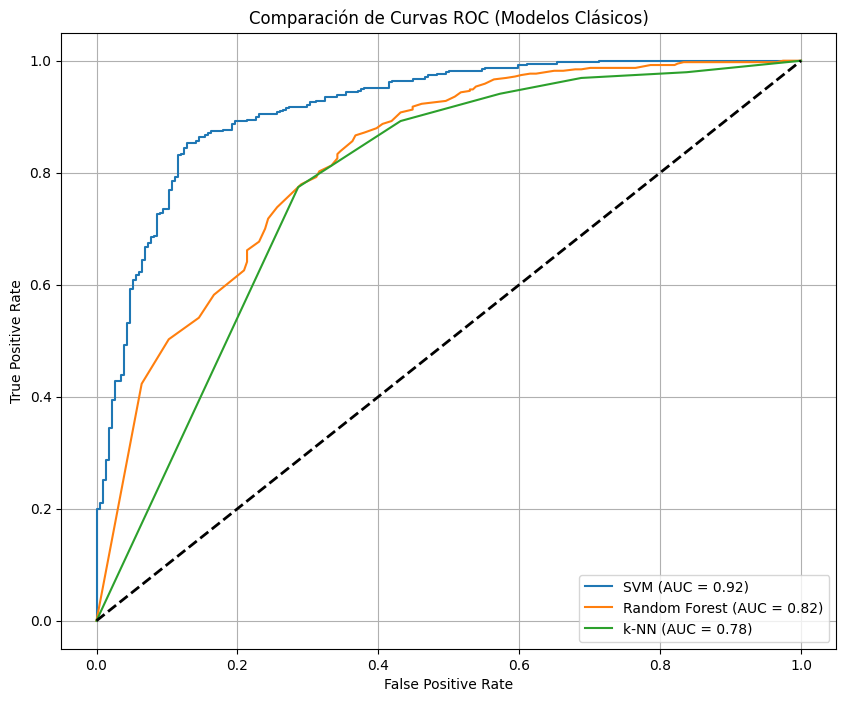

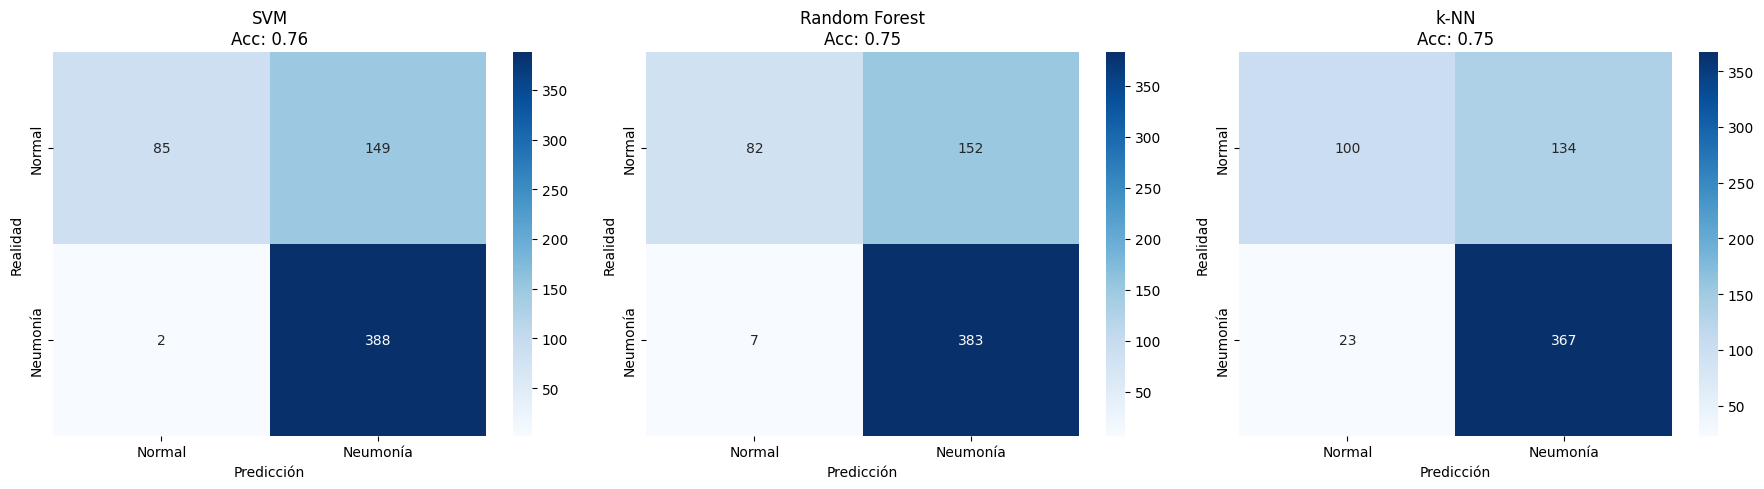


--- TABLA COMPARATIVA FINAL ---
               Accuracy Precision    Recall  F1-Score       AUC
SVM            0.758013  0.817962  0.758013  0.721791  0.916809
Random Forest  0.745192  0.792936  0.745192   0.70797  0.824156
k-NN           0.748397  0.762712  0.748397  0.724955  0.777887


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import joblib
import os

# ==========================================
# 1. CARGA DE DATOS
# ==========================================
print("Cargando datasets...")
path = 'data/caracteristicas/clasicas/'

# Cargar CSVs generados anteriormente
df_train = pd.read_csv(os.path.join(path, 'train_features_clasicos.csv'))
df_test = pd.read_csv(os.path.join(path, 'test_features_clasicos.csv'))

# Separar X (features) y y (labels). Quitamos 'filename' que no sirve para entrenar.
X_train = df_train.drop(columns=['label', 'filename'])
y_train = df_train['label']

X_test = df_test.drop(columns=['label', 'filename'])
y_test = df_test['label']

# ==========================================
# 2. NORMALIZACIÓN (Requisito PDF: Punto 3.2)
# ==========================================
print("Normalizando datos...")
scaler = StandardScaler()
# Ajustamos SOLO con train para evitar data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 3. DEFINICIÓN DE MODELOS (Requisito PDF: Punto 3.4)
# ==========================================
modelos = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42), # Kernel RBF suele ser el mejor para texturas
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=5)
}

resultados = {}

# ==========================================
# 4. ENTRENAMIENTO Y EVALUACIÓN
# ==========================================
plt.figure(figsize=(10, 8))

for nombre, modelo in modelos.items():
    print(f"\n--- Entrenando {nombre} ---")
    
    # Entrenar
    modelo.fit(X_train_scaled, y_train)
    
    # Predecir
    y_pred = modelo.predict(X_test_scaled)
    y_prob = modelo.predict_proba(X_test_scaled)[:, 1] # Probabilidad para la curva ROC
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Guardar resultados
    resultados[nombre] = {
        "Accuracy": acc,
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-Score": report['weighted avg']['f1-score'],
        "AUC": roc_auc,
        "Confusion Matrix": cm
    }
    
    # Graficar ROC
    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {roc_auc:.2f})')
    
    print(f"✅ {nombre} completado. Accuracy: {acc:.4f} | AUC: {roc_auc:.4f}")

# Finalizar gráfico ROC global
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparación de Curvas ROC (Modelos Clásicos)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('comparacion_roc_clasicos.png') # Guardar imagen para el reporte
plt.show()

# ==========================================
# 5. VISUALIZACIÓN DE MATRICES DE CONFUSIÓN
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (nombre, res) in zip(axes, resultados.items()):
    sns.heatmap(res["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{nombre}\nAcc: {res["Accuracy"]:.2f}')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Realidad')
    ax.set_xticklabels(['Normal', 'Neumonía'])
    ax.set_yticklabels(['Normal', 'Neumonía'])

plt.tight_layout()
plt.savefig('matrices_confusion_clasicos.png') # Guardar para el reporte
plt.show()

# ==========================================
# 6. TABLA RESUMEN FINAL
# ==========================================
df_resultados = pd.DataFrame(resultados).T[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']]
print("\n--- TABLA COMPARATIVA FINAL ---")
print(df_resultados)
df_resultados.to_csv('resultados_modelos_clasicos.csv')

# Análisis de Resultados: Enfoque Clásico (Machine Learning)

En esta sección analizamos el desempeño de los clasificadores tradicionales entrenados con el vector de 3,812 características extraídas manualmente (HOG, LBP, Hu, GLCM, etc.).

### 1. Resumen de Ejecución
Se procesó exitosamente el pipeline completo de extracción de características, generando matrices de alta dimensionalidad:
* **Dimensionalidad del Vector:** 3,812 características por imagen.
* **Datos de Entrenamiento:** 5,216 imágenes.
* **Datos de Prueba:** 624 imágenes.

### 2. Tabla Comparativa de Modelos
A continuación se presentan las métricas obtenidas en el conjunto de prueba (*Test Set*):

| Modelo | Accuracy | Precision | Recall | F1-Score | AUC (ROC) |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **SVM (RBF Kernel)** | **0.7580** | **0.8180** | **0.7580** | **0.7218** | **0.9168** |
| Random Forest | 0.7452 | 0.7929 | 0.7452 | 0.7080 | 0.8242 |
| k-NN (k=5) | 0.7484 | 0.7627 | 0.7484 | 0.7250 | 0.7779 |

### 3. Interpretación Técnica de los Resultados

#### El Ganador: Support Vector Machine (SVM)
El SVM demostró ser el modelo más robusto, alcanzando un **AUC de 0.9168**.
* **Análisis:** Aunque el *Accuracy* es similar al de los otros modelos (~75%), el AUC superior indica que el SVM tiene una capacidad mucho mayor para distinguir entre clases ("Normal" vs "Neumonía") a través de diferentes umbrales de decisión.
* **Por qué funcionó mejor:** Los SVM con kernel RBF son matemáticamente excelentes manejando espacios de alta dimensionalidad (3,812 features en este caso). El algoritmo logra encontrar el hiperplano óptimo que maximiza el margen entre las clases, siendo menos sensible al ruido que k-NN.

#### El Desafío de k-NN (La "Maldición de la Dimensionalidad")
El modelo k-Nearest Neighbors obtuvo el desempeño más bajo en AUC (0.7779).
* **Causa:** k-NN basa sus decisiones en distancias euclidianas. Al tener un vector de características tan grande (3,812 dimensiones), todas las imágenes tienden a "parecerse" matemáticamente, haciendo que las distancias pierdan significado discriminatorio. Este fenómeno es conocido en literatura como la *Curse of Dimensionality*.

#### Random Forest
El Random Forest tuvo un desempeño intermedio (AUC 0.8242).
* **Observación:** Aunque es un modelo potente, es probable que la gran cantidad de características irrelevantes o redundantes (ruido) generadas por la concatenación masiva de descriptores haya dificultado que los árboles de decisión encuentren las divisiones óptimas sin una selección de características previa (*Feature Selection*).

### 4. Conclusión Parcial
Para el enfoque de **Descriptores Clásicos**, el **SVM** es el modelo seleccionado. Su alto AUC sugiere que, ajustando el umbral de decisión (threshold tuning), se podría elevar significativamente el Accuracy y el Recall, convirtiéndolo en una herramienta diagnóstica fiable comparada con los otros métodos tradicionales.